# FER2013 preprocessing for MobileNetV2(GrayScale  48x48)

In [1]:
# imports with aliases
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from pathlib import Path

# from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Configuration
plt.style.use('ggplot')
%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print versions
print(f"TensorFlow Version: {tf.__version__}")
print(f"OpenCV Version: {cv2.__version__}")

# Define constants
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
INPUT_SHAPE = (*IMG_SIZE, 1)  # Grayscale single channel


2025-07-13 20:38:33.612486: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 20:38:33.623156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-13 20:38:33.779358: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-13 20:38:33.784830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-13 20:38:36.150031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

TensorFlow Version: 2.13.0
OpenCV Version: 4.8.0


In [2]:
# Define base directory and paths
BASE_DIR = '../../data/raw/fer2013/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

#Update the classes
SELECTED_CLASSES = ["angry", "happy", "sad", "surprise", "neutral"]
NUM_CLASSES = len(SELECTED_CLASSES)

print(f"Selected classes: {SELECTED_CLASSES}")
print(f"Input shape: {INPUT_SHAPE}")

# CLASS_NAMES = sorted(list(set(EMOTION_MAP.values())))
# NUM_CLASSES = len(CLASS_NAMES)

# print(f"Classes after merging: {CLASS_NAMES}")
# print(f"Number of classes: {NUM_CLASSES}")

Selected classes: ['angry', 'happy', 'sad', 'surprise', 'neutral']
Input shape: (48, 48, 1)


In [4]:
def preprocess_image(img_path):
    """
    Basic preprocessing for FER2013 images:
    - Load as grayscale
    - Normalize to [0, 1]
    - Add channel dimension
    """
    # Load image (already grayscale 48x48)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize to [0, 1]
    img_normalized = img.astype(np.float32) / 255.0
    
    # Add channel dimension for CNN: (48, 48) → (48, 48, 1)
    img_final = np.expand_dims(img_normalized, axis=-1)
    
    return img_final

def load_and_preprocess_data(directory, valid_classes):
    """
    Load images and labels from directory, apply preprocessing
    """
    images = []
    labels = []
    
    for emotion in os.listdir(directory):
        if emotion not in valid_classes:
            continue
        emotion_path = os.path.join(directory, emotion)
        for img_file in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_file)
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(emotion)
    return np.array(images), np.array(labels)

X_train, y_train = load_and_preprocess_data(TRAIN_DIR, SELECTED_CLASSES)
X_test, y_test = load_and_preprocess_data(TEST_DIR, SELECTED_CLASSES)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (24176, 48, 48, 1)
Test data shape: (6043, 48, 48, 1)


In [5]:
# Convert string labels to numerical labels
label_to_index = {emotion: idx for idx, emotion in enumerate(SELECTED_CLASSES)}
index_to_label = {idx: emotion for emotion, idx in label_to_index.items()}

# Convert string labels to numerical
y_train_num = np.array([label_to_index[label] for label in y_train])
y_test_num = np.array([label_to_index[label] for label in y_test])

# One-hot encode labels
y_train_encoded = to_categorical(y_train_num, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test_num, num_classes=NUM_CLASSES)

# Calculate class weights for handling imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_num),
    y=y_train_num
)
class_weights = dict(enumerate(class_weights))

print("\nClass weights for handling imbalance:")
for idx, weight in class_weights.items():
    print(f"{index_to_label[idx]}: {weight:.2f}")


Class weights for handling imbalance:
angry: 1.21
happy: 0.67
sad: 1.00
surprise: 1.52
neutral: 0.97



Augmented training samples:


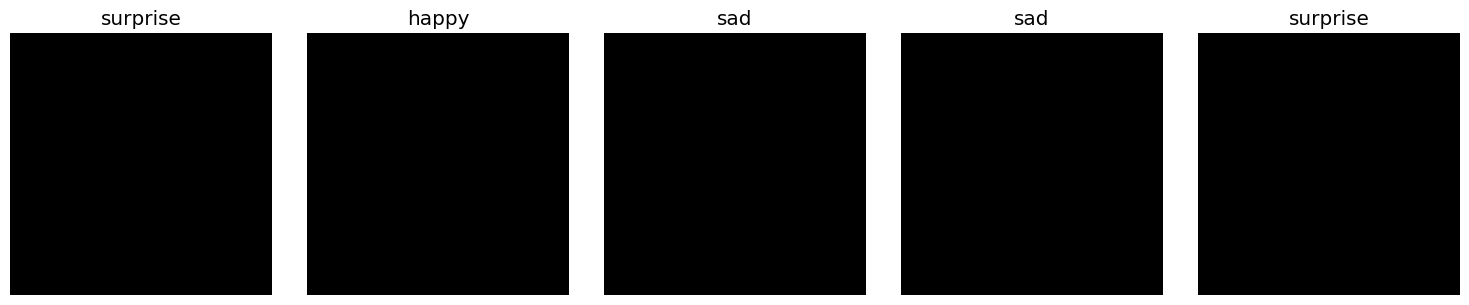

In [6]:
# Create data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=15,          # ±15 degrees
    width_shift_range=0.1,      # ±10% horizontal shift
    height_shift_range=0.1,     # ±10% vertical shift
    brightness_range=[0.9, 1.1], # ±10% brightness
    zoom_range=0.1,             # ±10% zoom
    horizontal_flip=True,       # 50% chance (be careful with asymmetric emotions)
    fill_mode='nearest'         # Fill missing pixels
)

# Validation/test generator (only normalization)
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(
    X_train,
    y_train_encoded,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = test_datagen.flow(
    X_test,
    y_test_encoded,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Visualize augmented samples
def plot_augmented_samples(generator, n_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        # Get a batch of augmented images
        for X_batch, y_batch in generator:
            # Convert grayscale to RGB for display
            img = np.squeeze(X_batch[0])
            label = index_to_label[np.argmax(y_batch[0])]
            
            plt.subplot(1, n_samples, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(label)
            plt.axis('off')
            break  
    plt.tight_layout()
    plt.show()

print("\nAugmented training samples:")
plot_augmented_samples(train_generator)

In [7]:
# Create directory for processed data
PROCESSED_DIR = '../../data/processed/FC211042_Heshani'
os.makedirs(PROCESSED_DIR, exist_ok=True)

# make sure X_train, y_train_encoded, index_to_label already exist
train_out = Path(PROCESSED_DIR) / "train"
test_out  = Path(PROCESSED_DIR) / "test"
train_out.mkdir(parents=True, exist_ok=True)
test_out.mkdir(parents=True,  exist_ok=True)

def save_images(array, labels, root_dir):
    for idx, (img, label_vec) in enumerate(zip(array, labels)):
        class_name = index_to_label[int(np.argmax(label_vec))]
        class_dir  = root_dir / class_name
        class_dir.mkdir(exist_ok=True)
        img_uint8  = (img.squeeze() * 255).astype("uint8")      # back to 0‑255
        file_path  = class_dir / f"{idx:06d}.jpg"
        cv2.imwrite(str(file_path), img_uint8)

# save train and test sets
save_images(X_train, y_train_encoded, train_out)
save_images(X_test,  y_test_encoded,  test_out)

print("Preprocessed data saved successfully!")

Preprocessed data saved successfully!
